# Session 4

## CNN Literature Architectures

Over the years, different architectures have been developed, leading to amazing advances in the field of computer vision. A good measure of this progress is the error rate in competitions such as the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) challenge. In this competition the top-5 error rate for image classification fell from over 26% to less than 2.3% in just six years. (The top-five error rate is the number of test images for which the system’s top 5 predictions did not include the correct answer). Check this [link](https://paperswithcode.com/sota/image-classification-on-imagenet) for ImageNet data progress.

The images are large (256 pixels high) and there are 1,000 classes, some of which are really subtle (try distinguishing 120 dog breeds).
Looking at the evolution of the winning entries is a good way to understand how CNNs work. We will take a glimpse at:
- The classical LeNet-5 architecture
- AlexNet
- GoogLeNet
- ResNet
- Xception
- SENet

### LeNet-5 

The network architecture is simply straightforward as follows:

<img src="./images/lenet.png"/>

But there are some important things to note:

- Typically the MNIST images that were used are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.

- The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.

- Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). According to the original paper, first this non-complete connection scheme keeps the of connections whitin reasonable bounds. More importantly, it forces a break of symmetry in the network. Different feature maps are forced to extract different features because they get different sets of inputs (*This is alittle bit similar to the idea of dropout*)

A great demos can be found on Yann LeCun's website [here](http://yann.lecun.com/)

### AlexNet

The AlexNet CNN architecture won the 2012 ImageNet ILSVRC challenge by a large margin: it achieved 17% top-5 error rate while the second best achieved only
26%! It was developed by Alex Krizhevsky (hence the name), Ilya Sutskever, and Geoffrey Hinton. It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer.

<img src="./images/alexnet.png"/>

As, we are just mentioned, it's much larger and deeper model. That's why it is more prone to overfitting. That's why dropout was applied with a 50% dropout rate during training to the outputs of layers F8 and F9. Additionally, they performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.


**Local response normalization**

In neurobiology, there is a concept called “lateral inhibition”. Now what does that mean? This refers to the capacity of an excited neuron to suppress its neighbors. We basically want a significant peak so that we have a form of local maxima. This tends to create a contrast in that area, hence increasing the sensory perception. Increasing the sensory perception is a good thing! We want to have the same thing in our CNNs.

Local Response Normalization (LRN) layer implements the lateral inhibition we were talking about in the previous section. This layer is useful when we are dealing with ReLU neurons. Why is that? Because ReLU neurons have unbounded activations and we need LRN to normalize that. We want to detect high frequency features with a large response. If we normalize around the local neighborhood of the excited neuron, it becomes even more sensitive as compared to its neighbors.

At the same time, it will dampen the responses that are uniformly large in any given local neighborhood. If all the values are large, then normalizing those values will diminish all of them. So basically we want to encourage some kind of inhibition and boost the neurons with relatively larger activations.

AlexNet uses local response normalization as a competitive normalization step immediately after the ReLU step of layers C1 and C3. The most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps (such competitive activation has been observed in biological neurons). This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization.

This can be implemented using `tf.nn.local_response_normalization()` function (which you can wrap in a Lambda layer if you want to use it in a Keras model).

### GoogLeNet

The GoogLeNet architecture was developed by Christian Szegedy et al. from Google Research, and it won the ILSVRC 2014 challenge by pushing the top-5 error rate below 7%. This great performance came in large part from the fact that the network was much deeper than previous CNNs. This was made possible by
subnetworks called *inception* modules, which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).


<img src= "./images/inception.png"/>


The is the architecture of an inception module. The notation “3 × 3 + 1(S)” means that the layer uses a 3 × 3 kernel, stride 1, and SAME padding. The input
signal is first copied and fed to four different layers. All convolutional layers use the ReLU activation function. Note that the second set of convolutional layers uses different kernel sizes (1 × 1, 3 × 3, and 5 × 5), allowing them to capture patterns at different scales. Also note that every single layer uses a stride of 1 and SAME padding (even the max pooling layer), so their outputs all have the same height and width as their inputs. This makes it possible to concatenate all the outputs along the depth dimension in the final depth concat layer (i.e., stack the feature maps from all four top convolutional layers). This concatenation layer can be implemented in TensorFlow using the tf.concat() operation, with axis=3 (axis 3 is the depth).


The important concept to capture from this model is the 1x1 kernel layer.

It's an important concept and has three main purposes:

- First, although they cannot capture spatial patterns, they can capture patterns along the depth dimension (Think of multi feature maps stacked on top of each others)
- Second, they are configured to output fewer feature maps than their inputs, so they serve as bottleneck layers, meaning they reduce dimensionality. This cuts the computational cost and the number of parameters, speeding up training and improving generalization.
- Lastly, each pair of convolutional layers ([1 × 1, 3 × 3] and [1 × 1, 5 × 5]) acts like a single, powerful convolutional layer, capable of capturing more complex patterns.

<img src= "./images/googlenet.png"/>


Let’s go through this network:
- The first two layers divide the image’s height and width by 4 (so its area is divided by 16), to reduce the computational load. The first layer uses a large kernel size, so that much of the information is still preserved.

- Then the local response normalization layer ensures that the previous layers learn a wide variety of features (as discussed earlier).

- Two convolutional layers follow, where the first acts like a bottleneck layer. As explained earlier, you can think of this pair as a single smarter convolutional layer.

- Again, a local response normalization layer ensures that the previous layers capture a wide variety of patterns.

- Next a max pooling layer reduces the image height and width by 2, again to speed up computations.

- Then comes the tall stack of nine inception modules, interleaved with a couple max pooling layers to reduce dimensionality and speed up the network.

- Next, the global average pooling layer simply outputs the mean of each feature map: this drops any remaining spatial information, which is fine since there was not much spatial information left at that point. Indeed, GoogLeNet input images are typically expected to be 224 × 224 pixels, so after 5 max pooling layers, each dividing the height and width by 2, the feature maps are down to 7 × 7. Moreover, it is a classification task, not localization, so it does not matter where the object is. Thanks to the dimensionality reduction brought by this layer, there is no need to have several fully connected layers at the top of the CNN (like in AlexNet), and this considerably reduces the number of parameters in the network and limits the risk of overfitting.

- The last layers are self-explanatory: dropout for regularization, then a fully connected layer with 1,000 units, since there are a 1,000 classes, and a softmax activation function to output estimated class probabilities.

### VGGNet

The runner up in the ILSVRC 2014 challenge was VGGNet14, developed by K. Simonyan and A. Zisserman. It had a very simple and classical architecture, with 2 or 3 convolutional layers, a pooling layer, then again 2 or 3 convolutional layers, a pooling layer, and so on (with a total of just 16 convolutional layers), plus a final dense network with 2 hidden layers and the output layer. It used only 3 × 3 filters, but many filters. *deeper with fewer parameters*

Recall the VGG block from the last session?

### ResNet

The ILSVRC 2015 challenge was won using a Residual Network (or ResNet), developed by Kaiming He et al.,15 which delivered an astounding top-5 error rate under 3.6%, using an extremely deep CNN composed of 152 layers. It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters. The key to being able to train such a deep network is to use skip connections (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. Let’s see why this is useful.

When training a neural network, the goal is to make it model a target function h(x). If you add the input x to the output of the network (i.e., you add a skip connection), then the network will be forced to model f(x) = h(x) – x rather than h(x) and this speeds up the training considerably. This is called residual learning.

<img src="./images/res1.png"/>


If you add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units, where each residual unit is a small neural network with a skip connection.

<img src="./images/res2.png"/>


Now let's look at ResNet’s architecture

<img src="./images/resnet.png"/>

Note that the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). When this happens the inputs cannot be added directly to the outputs of the residual unit since they don’t have the same shape (for example, this problem affects the skip connection represented by the dashed arrow). To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps

<img src="./images/resnetsol.png"/>

### Xception *Extreme Inception*

It replaces the inception modules with a special type of layer called a depthwise separable convolution (or separable convolution for short). These layers had been used before in some CNN architectures, but they were not as central as in the Xception architecture. While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g., an oval) and crosschannel patterns (e.g., mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately. Thus, it is composed of two parts: the first part applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns—it is just a regular convolutional layer with 1 × 1 filters.

> This should be used after layers with so many channels (not with the inputs)

<img src="./images/crosscnn.png"/>



### SENet

The winning architecture in the ILSVRC 2017 challenge was the Squeeze-andExcitation Network (SENet). This architecture extends existing architectures such as inception networks or ResNets, and boosts their performance. This allowed SENet to win the competition with an astonishing 2.25% top-5 error rate! The extended versions of inception networks and ResNet are called SE-Inception and SE-ResNet respectively. The boost comes from the fact that a SENet adds a small neural network, called a SE Block, to every unit in the original architecture (i.e., every inception module or every residual unit).

<img src="./images/seblock.png"/>

A SE Block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension (it does not look for any spatial pattern), and it learns which features are usually most active together. It then uses this information to recalibrate the feature maps. For example, a SE Block may learn that mouths, noses and eyes usually appear together in pictures: if you see a mouth and a nose, you should expect to see eyes as well. So if a SE Block sees a strong activation in the mouth and nose feature maps, but only mild activation in the eye feature map, it will boost the eye feature map (more accurately, it will reduce irrelevant feature maps). If the eyes were somewhat confused with something else, this feature map recalibration will help resolve the ambiguity.

<img src="./images/seblock2.png"/>

A SE Block is composed of just 3 layers: a global average pooling layer, a hidden dense layer using the ReLU activation function, and a dense output layer using the sigmoid activation function.

<img src="./images/seblock3.png"/>

The global average pooling layer computes the mean activation for each feature map: for example, if its input contains 256 feature maps, it will output 256 numbers representing the overall level of response for each filter. The next layer is where the “squeeze” happens: this layer has much less than 256 neurons, typically 16 times less than the number of feature maps (e.g., 16 neurons), so the 256 numbers get compressed into a small vector (e.g., 16 dimensional). This is a low-dimensional vector representation (i.e., an embedding) of the distribution of feature responses. This bottleneck step forces the SE Block to learn a general representation of the feature combinations. Finally, the output layer takes the embedding and outputs a recalibration vector containing one number per feature map (e.g., 256), each between 0 and 1. The feature maps are then multiplied by this recalibration vector, so irrelevant features (with a low recalibration score) get scaled down while relevant features (with a recalibration score close to 1) are left alone.

## ResNet-34 Implementation

This is a simple tutorial to buil ResNet from scratch, then we will learn how to access the pretrained models using keras applications.

In [1]:
from tensorflow import keras
from functools import partial
import numpy as np

In [2]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

Partial is a wrapper not to repeat the same parameters (kernel_size, padding, etc) over and over again

In [3]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation) # to be used for the final activation after the summation of the output and the skip connection if exists 
        # here goes the main layers (the core of the res building block)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        # here goes the conv layer in the path of the skip connection with 1x1 kernel in case of the number of filters change (from res block to another)
        # Also the strides value will be 2 (handled in the for loop later in the model building) 
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
    # the call function logic defines how the input is fed to the layers
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [4]:
model = keras.models.Sequential()
# this is the early layers (layers before the "block" in the resnet figure above)
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
##

## here comes the trick to add the desired number of residual units
# the following loop passes the number of filters = 64, and strides = 1 three times, then it changes the number of filters
# to be 128, only then the strides becomes 2 then it continues to pass 128 and strides = 1 for another 3 times, then when the 
# number of filters change from 128 to 256 the strides change from 1 to 2 then back to pass #filter = 256 and strides = 1 for
# another 5 time and so on 
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

## then comes the output layers after the "block" in the resnet figure above
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

Now, the model can be easily compiled with the needed loss function, metrics and optimizers then start fitting it you your data.

## Using pretrained models from keras for inference

Instead of building models like resnet, vgg or inception from scratch, we can have access to the pretrained models form `keras.applications`.

But, what does it mean to access the pretrained models?

As we mentioned, the learning process is about finding the best wieghts for the model that gives the minimum error. As we mentioned, those models have been trained on a large amount of images (more than 14 millions) and achieved some weight values, so what if we can use those achieved wights to make new inference as if we already performed the training process and now we are making a new prediciton. Let's see how we can do this:

In [6]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np

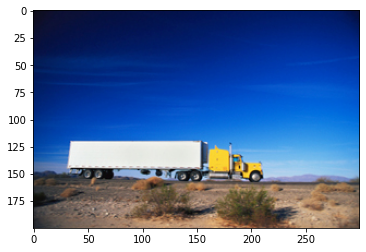

In [7]:
# we load any image that we need the model to make a prediction on
img = cv2.imread("./images/truck.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Each one from the models that we discussed performed some set of preprocessing operations, some of them usually pad the input to a larger size, some other models normalize the input images...so if we need the model to make an inference for us, we have to pass something that makes sense for it as it has been learnt during the training phase. That's why we need to perform some resizing to match the expected input shape.

We can know the expected input shape with different methods such as:
- after importing the model, we can have a look at the first layer (input layer) or showing `model.summary()`
- we can have a look on the documentation page of the model

As, I will be using resnet next, I need to match the expected input shape which is as follows (some number of examples, 224, 224, 3). So, the model is expecting a tensor holds the images that will be processed, each one of them is 244 x 244 pixels and with 3 channels.

Here I'm using opencv and numpy functions, also you can have a look over `tf.image`

In [8]:
img = cv2.resize(img, (224, 224))

In [9]:
img = np.array([img])
img.shape

(1, 224, 224, 3)

> Note, if we have more than one image, we can append them to the tensor, to be of shape (2, 224, 244, 3)

Now, we need to know the specific preprocessing steps the images received while the model was trained to apply them to our images, instead for searching for them and risking implementing them from scratch we can have access to them using `keras.applications.resnet50.preprocess_input`. Each pretrained model has a similar funciton that holds the required preprocessing for it. Let's look at what this funciton does unsing `keras.applications.resnet50.preprocess_input?`

In [10]:
keras.applications.resnet50.preprocess_input?

Signature: keras.applications.resnet50.preprocess_input(x, data_format=None)
Docstring:
Preprocesses a tensor or Numpy array encoding a batch of images.

Usage example with `applications.MobileNet`:

```python
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet.preprocess_input(x)
core = tf.keras.applications.MobileNet()
x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

image = tf.image.decode_png(tf.io.read_file('file.png'))
result = model(image)
```

Args:
  x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
    channels, with values in the range [0, 255].
    The preprocessed data are written over the input data
    if the data types are compatible. To avoid this
    behaviour, `numpy.copy(x)` can be used.
  data_format: Optional data format of the image tensor/array. Defaults to
    None, in which case the global setting
    `tf.keras.backend.image_data_format()` is used (unles

As we can see, it expects a tensor with 3 color channels with values in range [0, 255] and it shall convert it from RGB to BGR, then each color channel is zero-centered with respect to the imageNet dataset (means that shift parameter was calculated for the imagenet images and used here for transformation), without scaling. So, our image is ready to get passes to this function.

In [11]:
inputs = keras.applications.resnet50.preprocess_input(img)

Now, let's get our model here. We will use ResNet50 from `keras.applications`, (from which we can access other pretrained models). We will pass "imagenet" to the weights parametes meaning that we need the achieved weights over the imagenet dataset not new randomly initialized weights.

In [12]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [13]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Now, as we said that this model is *pretrained*, we can jump to the inference directly.

In [14]:
Y_proba = model.predict(inputs)

In [15]:
Y_proba.shape

(1, 1000)

Here, the model outputs a vector of 1000 probability values by which the image belongs to a certain class out of the 1000 classes known in imagenet. So, we can use `argmax` to get the index with maximum probability value and search over the documentation to know the class name of this index. Instead, we can use the `decode_predictions` to do this for us. Moreover, we can pass the number of top predictions that we are interested in.

In [16]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5)

In [17]:
top_K

[[('n04467665', 'trailer_truck', 0.99275726),
  ('n03796401', 'moving_van', 0.005943512),
  ('n03393912', 'freight_car', 0.0009232601),
  ('n03417042', 'garbage_truck', 0.00018813994),
  ('n03126707', 'crane', 5.3126198e-05)]]

Here comes the top 5 predictions for our image. We can notice the high confidence of 99.27% of the top prediction and also the remaining four are not that far from the correct answer. No need to forget that the model chooses the correct class out of 1000 classes.

Now, suppose we want our model to choose only the correct class out of only 5 classes to have a better measure and confidence. Or maybe we want the model to predict a class that doesn't exist in the 1000 classes of the imagenet. How can we do this?

One way is to create the model without the pretrained wights, tweak it to be suitable for our task then start training it on our data. This is bad, why?

- First, those models are very deep with multiple layers and blocks, they would consume so much time and resources
- Second, they will need a huge amount of data (think of the 14 millions and more with data augmentation that they were trained on). and I'm pretty sure your task doesn't have that much data. Otherwise, the model will overfit your images.
- Third, you will lose what the model has learnt over the imagenet.

So, it would be great if there's a way to transfer the model's knowledge to our tasks. This can be done using ***Transfer Learning***

## Pretrained Models for Transfer Learning

Think of transfer learning as introducing a new programming language to an expert software engineer. He knows what conditions, loops and functions mean, but needs to have a look at the new syntax and how he can utilize what he knows over this new language.

Transfer learning is similar to this, You make use of the pretrained model after it has became an expert in the concept of image and objects in images. Now, you want to teach it the new data (your data) style.

In the context of CNNs, we mentioned that early layers are interested in low level features. Those low level features are common and they define what an image (every image) is. Think of the vertical, horizontal lines or circles. Additionally, the upper level layers are interested in combining those features into more complex features (think of the lines and circles now forming shapes of faces, objects, etc.).

So, if you keep the low-layers' weights, you are keeping the knowledge of the expert model. Then, you add new top layers (not trained yet), to be trained on your new data, to be able to learn how the complex features of your data can be formed.

Let's see this in action with the inception model working with flowers dataset (from tensorflow_datasets)

In [7]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
import tensorflow as tf
from tensorflow import keras
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [8]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [9]:
n_classes = info.features["label"].num_classes

In [10]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

You can have a look on the [new split API](https://www.tensorflow.org/datasets/splits) for more details and more easier splitting

In [11]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

This is a sample of the images before the preprocessing

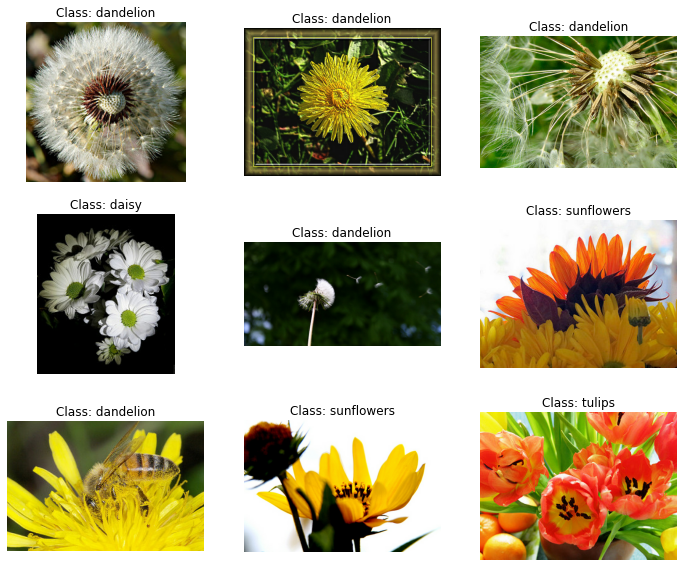

In [12]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing (resizing and model.preprocess_input):

In [13]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [14]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

And, This is a sample of the images after preprocessing

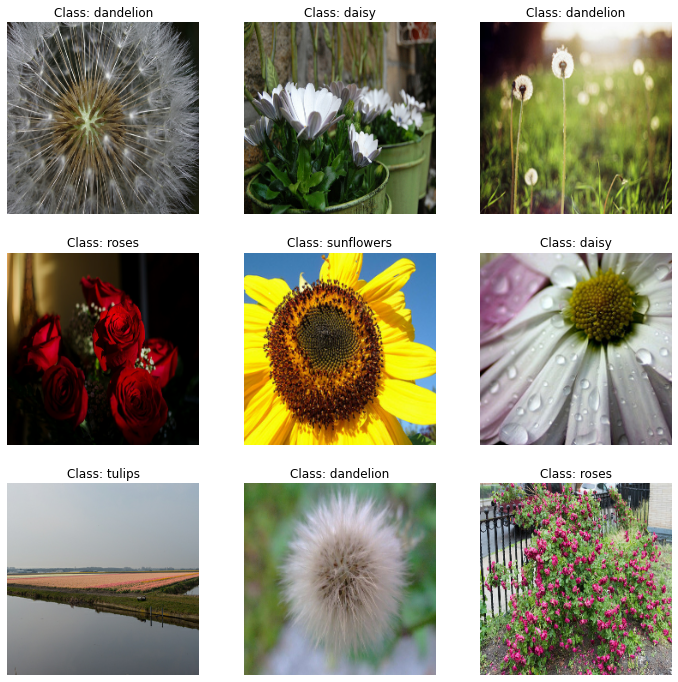

In [15]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Now, after preprocessing the data, we need to import the low layers of the model with the pretrained weights, excluding the output layers related to the imagenet data. Those are what we need to replace with new output layers that shall learn what our dataset is about. So, we pass `include_top = False`. And, stack on top of the rest of the mode a `GlobalAveragePooling2D` layer followed by `Dense` layer with number of units euqals to the number of classes we have.

> Note: as those added layers are similar to the output layers were in the original models, but the difference is that now they have new randomly initialized wiehgts not the pretrained ones, and those what we are interested in learning.

In [16]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


An important thing to mention is that at the begining of the training, we are expecting larger loss values. As the newly intialized weights didn't learn anything yet. So, those larger errors while backpropagate through the whole model can distort the pretrained wieghts that we've loaded. On the other hand, we need them to get affected by the error on the new dataset to be well-learnt *but not distorted*

That's why we start learning while have those weights freezed (*non-trainable*), till we have good values for the validation loss and validation accuracy. Only then, we can unfreeze those weights allowing the whole model weights to be trained.

In [17]:
#freeze the model weights (now, only the weights of the global avgpooling layer and the following dense layer will be updated while training)
for layer in base_model.layers:
    layer.trainable = False

# we use a larger learning rate and a small number of epochs to get those weights converged quickly
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 26s 162ms/step - loss: 1.7853 - accuracy: 0.7707 - val_loss: 1.4601 - val_accuracy: 0.8327
Epoch 2/5
86/86 [==============================] - 13s 151ms/step - loss: 0.5591 - accuracy: 0.9095 - val_loss: 0.9491 - val_accuracy: 0.8695
Epoch 3/5
86/86 [==============================] - 13s 154ms/step - loss: 0.2495 - accuracy: 0.9426 - val_loss: 0.7939 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 14s 159ms/step - loss: 0.1488 - accuracy: 0.9582 - val_loss: 0.8196 - val_accuracy: 0.8640
Epoch 5/5
86/86 [==============================] - 14s 159ms/step - loss: 0.0794 - accuracy: 0.9753 - val_loss: 0.7554 - val_accuracy: 0.8676


In [18]:
#unfreeze the pretrained weights
for layer in base_model.layers:
    layer.trainable = True

#now we choose a smaller learning rate with higher number of epochs, to make sure that we are affecting the pretrained weights with smaller changes
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 63s 646ms/step - loss: 0.3597 - accuracy: 0.8881 - val_loss: 0.5554 - val_accuracy: 0.8658
Epoch 2/40
86/86 [==============================] - 54s 624ms/step - loss: 0.0489 - accuracy: 0.9866 - val_loss: 0.4827 - val_accuracy: 0.8824
Epoch 3/40
86/86 [==============================] - 54s 629ms/step - loss: 0.0238 - accuracy: 0.9938 - val_loss: 0.4161 - val_accuracy: 0.8989
Epoch 4/40
86/86 [==============================] - 55s 645ms/step - loss: 0.0265 - accuracy: 0.9909 - val_loss: 0.3589 - val_accuracy: 0.9026
Epoch 5/40
86/86 [==============================] - 55s 644ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.4414 - val_accuracy: 0.8879
Epoch 6/40
86/86 [==============================] - 56s 649ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.3283 - val_accuracy: 0.9136
Epoch 7/40
86/86 [==============================] - 55s 643ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.3286 - val_accuracy: 0.9191

As we can see, with very small amount of data relative to how deep our model is, we can achieve pretty much good score using ***Transfer learning.***

## Sources

- Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly). Copyright 2019 Aurélien Géron, 978-1-492-03264-9
- https://prateekvjoshi.com/2016/04/05/what-is-local-response-normalization-in-convolutional-neural-networks/
- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
- http://introtodeeplearning.com/
- https://course.fast.ai/
- https://pyimagesearch.com/
- https://sisu.ut.ee/imageprocessing/book/6
- https://www.simplilearn.com/image-processing-article
- https://pythonprogramming.net/color-filter-python-opencv-tutorial/
- https://www.analyticsvidhya.com/blog/2021/05/image-processing-using-opencv-with-practical-examples/#h2_11
- https://www.youtube.com/watch?v=1_hwFc8PXVE&list=PL2zRqk16wsdorCSZ5GWZQr1EMWXs2TDeu&index=7